### Subtask:
Visualize model loss during training.

**Reasoning**:
Plot the training and validation loss over epochs to evaluate the model's learning process and identify potential overfitting.

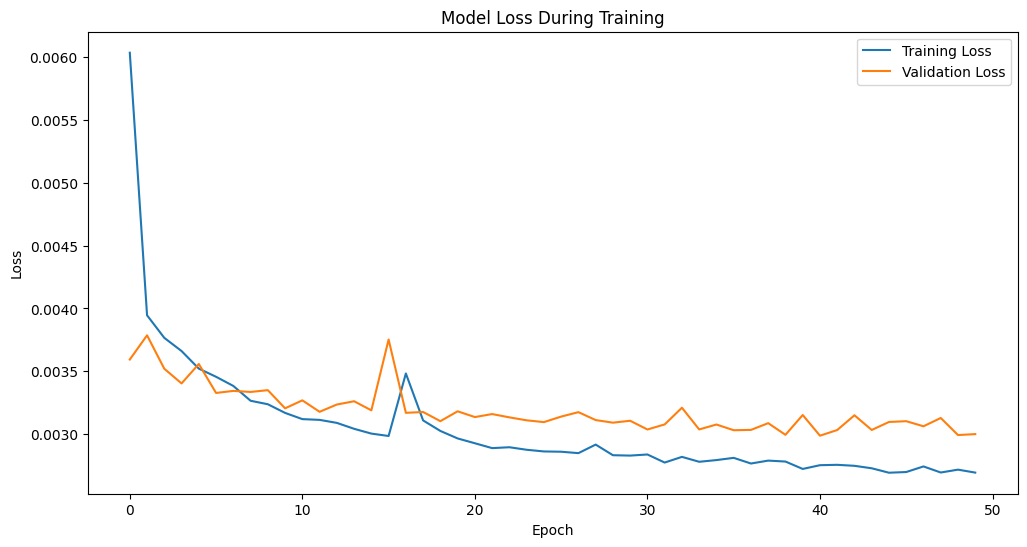

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Subtask:
Calculate evaluation metrics for the predictions.

**Reasoning**:
Calculate Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) to quantify the model's performance.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.0027520380017359938
Root Mean Squared Error (RMSE): 0.0524598703938162
Mean Absolute Error (MAE): 0.02975979865536858


### Subtask:
Visualize actual vs predicted precipitation.

**Reasoning**:
Plot the actual vs predicted precipitation to visually assess the model's performance.

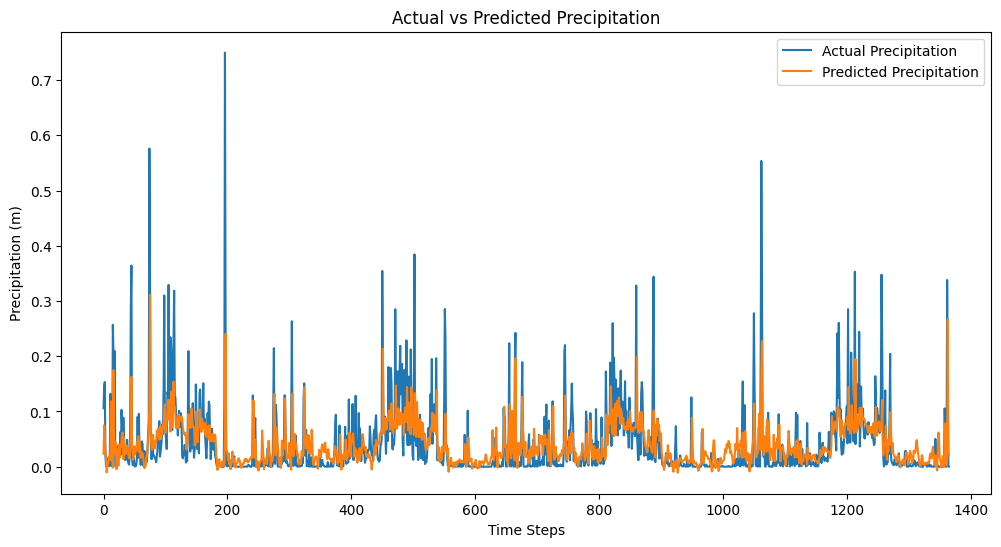

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Precipitation')
plt.plot(y_pred, label='Predicted Precipitation')
plt.title('Actual vs Predicted Precipitation')
plt.xlabel('Time Steps')
plt.ylabel('Precipitation (m)')
plt.legend()
plt.show()

## Evaluate and Visualize Results

### Subtask:
Make predictions using the trained model on the test data and inverse transform the predictions and actual values to the original scale.

**Reasoning**:
Make predictions using the trained model on the test data and inverse transform the predictions and actual values to the original scale using the saved `target_scaler`.

In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test_original:", y_test_original.shape)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Shape of y_pred: (1366, 1)
Shape of y_test_original: (1366, 1)


# Task
Analyze the weather data in "/content/chorabari_era5_weather_2000_2024.xlsx" to predict precipitation using a hybrid CNN-LSTM model.

## Load and prepare data

### Subtask:
Load the Excel data into a pandas DataFrame and perform quality filtering by checking for and addressing any missing values or outliers.


**Reasoning**:
Import pandas, load the Excel file, and display the head and info of the dataframe to understand its structure and identify missing values.



In [ ]:
import pandas as pd

df = pd.read_excel('/content/chorabari_era5_weather_2000_2024.xlsx')
display(df.head())
display(df.info())

system:index       date       dew_k  precip_m      press_pa      temp_k  \
0      20000101 2000-01-01  256.804244  0.000068  61409.008669  267.089099   
1      20000102 2000-01-02  256.652397  0.000081  61407.927968  267.298202   
2      20000103 2000-01-03  256.287709  0.000056  61281.264994  266.908866   
3      20000104 2000-01-04  256.610572  0.000467  61291.810073  265.780559   
4      20000105 2000-01-05  254.977764  0.000299  61229.414445  264.470593   

     u_wind    v_wind                                    .geo  
0 -0.157489 -0.403979  {"type":"MultiPoint","coordinates":[]}  
1 -0.118425 -0.393750  {"type":"MultiPoint","coordinates":[]}  
2 -0.162057 -0.371028  {"type":"MultiPoint","coordinates":[]}  
3 -0.208277 -0.413409  {"type":"MultiPoint","coordinates":[]}  
4 -0.244464 -0.436819  {"type":"MultiPoint","coordinates":[]}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   system:index  9131 non-null   int64         
 1   date          9131 non-null   datetime64[ns]
 2   dew_k         9131 non-null   float64       
 3   precip_m      9131 non-null   float64       
 4   press_pa      9131 non-null   float64       
 5   temp_k        9131 non-null   float64       
 6   u_wind        9131 non-null   float64       
 7   v_wind        9131 non-null   float64       
 8   .geo          9131 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 642.2+ KB


None

**Reasoning**:
Check for missing values and display descriptive statistics to identify potential outliers.



In [ ]:
display(df.isnull().sum())
display(df.describe())

system:index    0
date            0
dew_k           0
precip_m        0
press_pa        0
temp_k          0
u_wind          0
v_wind          0
.geo            0
dtype: int64

system:index                 date        dew_k      precip_m  \
count  9.131000e+03                 9131  9131.000000  9.131000e+03   
mean   2.012065e+07  2012-07-01 00:00:00   265.093387  4.880989e-03   
min    2.000010e+07  2000-01-01 00:00:00   233.938588 -1.328827e-08   
25%    2.006040e+07  2006-04-01 12:00:00   256.895558  1.325639e-04   
50%    2.012070e+07  2012-07-01 00:00:00   264.931458  1.458389e-03   
75%    2.018097e+07  2018-09-30 12:00:00   275.048514  6.878286e-03   
max    2.024123e+07  2024-12-30 00:00:00   282.742843  1.312665e-01   
std    7.211509e+04                  NaN    10.661619  8.553160e-03   

           press_pa       temp_k       u_wind       v_wind  
count   9131.000000  9131.000000  9131.000000  9131.000000  
mean   61443.852096   270.962622    -0.257500    -0.333625  
min    60034.336633   252.665702    -1.173382    -1.631260  
25%    61273.694330   264.865030    -0.517424    -0.681208  
50%    61503.416397   271.034026    -0.270256    -0.381232  
75%    61674.296118   277.707778     0.010055     0.019752  
max    62229.694185   283.887785     0.687811     1.651258  
std      324.142864     7.235972     0.329361     0.460768

## Feature engineering

### Subtask:
Convert the date column to datetime objects, add cyclical features for the month and day of the year, and create additional weather-related features such as wind_speed and dew_point_depression_k.


**Reasoning**:
Convert the date column to datetime objects and create cyclical features for month and day of the year, along with wind speed and dew point depression features, as per the instructions.



In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365)
df['wind_speed'] = np.sqrt(df['u_wind']**2 + df['v_wind']**2)
df['dew_point_depression_k'] = df['temp_k'] - df['dew_k']
display(df.head())

NameError: name 'np' is not defined

**Reasoning**:
The previous code block failed because numpy was not imported. Import numpy and re-execute the code to create the new features.



In [ ]:
import numpy as np

df['date'] = pd.to_datetime(df['date'])
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365)
df['wind_speed'] = np.sqrt(df['u_wind']**2 + df['v_wind']**2)
df['dew_point_depression_k'] = df['temp_k'] - df['dew_k']
display(df.head())

system:index       date       dew_k  precip_m      press_pa      temp_k  \
0      20000101 2000-01-01  256.804244  0.000068  61409.008669  267.089099   
1      20000102 2000-01-02  256.652397  0.000081  61407.927968  267.298202   
2      20000103 2000-01-03  256.287709  0.000056  61281.264994  266.908866   
3      20000104 2000-01-04  256.610572  0.000467  61291.810073  265.780559   
4      20000105 2000-01-05  254.977764  0.000299  61229.414445  264.470593   

     u_wind    v_wind                                    .geo  month_sin  \
0 -0.157489 -0.403979  {"type":"MultiPoint","coordinates":[]}        0.5   
1 -0.118425 -0.393750  {"type":"MultiPoint","coordinates":[]}        0.5   
2 -0.162057 -0.371028  {"type":"MultiPoint","coordinates":[]}        0.5   
3 -0.208277 -0.413409  {"type":"MultiPoint","coordinates":[]}        0.5   
4 -0.244464 -0.436819  {"type":"MultiPoint","coordinates":[]}        0.5   

   month_cos   day_sin   day_cos  wind_speed  dew_point_depression_k  
0   0.866025  0.017213  0.999852    0.433592               10.284856  
1   0.866025  0.034422  0.999407    0.411174               10.645805  
2   0.866025  0.051620  0.998667    0.404876               10.621157  
3   0.866025  0.068802  0.997630    0.462911                9.169987  
4   0.866025  0.085965  0.996298    0.500573                9.492829

## Data scaling and structuring

### Subtask:
Apply MinMaxScaler to normalize all numerical features to a range of [0, 1], create a separate MinMaxScaler instance for the precip_m target variable, and structure the scaled data into sequences of 30 days (X) to predict the normalized precipitation of the next day (y).


**Reasoning**:
Apply MinMaxScaler to normalize the numerical features and the target variable, then structure the scaled data into sequences for model input.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
cols_to_scale = [col for col in numerical_cols if col not in ['date', 'system:index']]

feature_scaler = MinMaxScaler(feature_range=(0, 1))
df[cols_to_scale] = feature_scaler.fit_transform(df[cols_to_scale])

target_scaler = MinMaxScaler(feature_range=(0, 1))
df['precip_m_scaled'] = target_scaler.fit_transform(df[['precip_m']])

def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(df[cols_to_scale].values, df['precip_m_scaled'].values, seq_length)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (9101, 30, 12)
Shape of y: (9101,)


## Split data

### Subtask:
Split the dataset into training, validation, and testing sets using a 70/15/15 ratio.


**Reasoning**:
Calculate the sizes for training, validation, and testing sets and split the X and y arrays accordingly while maintaining the sequential order.



In [ ]:
total_sequences = X.shape[0]
train_size = int(total_sequences * 0.70)
val_size = int(total_sequences * 0.15)
test_size = total_sequences - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (6370, 30, 12)
Shape of y_train: (6370,)
Shape of X_val: (1365, 30, 12)
Shape of y_val: (1365,)
Shape of X_test: (1366, 30, 12)
Shape of y_test: (1366,)


## Build a hybrid cnn-lstm model

### Subtask:
Construct a sequential model with a Conv1D layer, a MaxPooling1D layer, an LSTM layer, and Dropout layers.


**Reasoning**:
Construct the CNN-LSTM sequential model with Conv1D, MaxPooling1D, LSTM, Dropout, and Dense layers as specified in the instructions.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,419 (99.29 KB)

 Trainable params: 25,419 (99.29 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and train the model

### Subtask:
Compile the model with the Adam optimizer and mean_squared_squared_error as the loss function, and train the model for a sufficient number of epochs.


**Reasoning**:
Compile and train the model as instructed.



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mse'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/

**Reasoning**:
The task is to load the data from the provided CSV file into a pandas DataFrame and display the first few rows to understand its structure.



In [ ]:
import pandas as pd

# Load the dataframe.
df = pd.read_csv('/data/Housing.csv')

# Display the first 5 rows.
display(df.head().to_markdown(index=False, numalign="left", stralign="left"))

FileNotFoundError: [Errno 2] No such file or directory: '/data/Housing.csv'

### Subtask:
Predict precipitation for the next 30 days.

### Subtask:
Predict precipitation for 1 year day by day and store in a new CSV.

**Reasoning**:
Extend the sequential prediction process to predict precipitation for 365 days, store the daily predictions, and save them to a CSV file.

In [ ]:
import pandas as pd

# Use the last 'seq_length' days of data from the original dataframe as the starting point
last_sequence_scaled = df[cols_to_scale].tail(seq_length).values

predicted_year_days = []
current_sequence = last_sequence_scaled.copy()

# Assuming the last date in the dataframe is the starting point for the 1-year prediction
last_date = df['date'].iloc[-1]
prediction_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 366)] # Predict for 365 days

for _ in range(365):
    # Reshape the current sequence for prediction
    X_current = current_sequence.reshape(1, seq_length, len(cols_to_scale))

    # Predict the next step
    next_step_scaled = model.predict(X_current)

    # Inverse transform the prediction
    next_step_original = target_scaler.inverse_transform(next_step_scaled)
    predicted_year_days.append(next_step_original[0][0])

    # Prepare the input for the next prediction:
    # Remove the oldest day and add the new prediction (scaled)

    # Create a dummy row for the predicted precipitation in the scaled feature space
    predicted_row_scaled = np.zeros((1, len(cols_to_scale)))
    precip_scaled_index = cols_to_scale.index('precip_m')
    predicted_row_scaled[:, precip_scaled_index] = next_step_scaled[0, 0]

    # For other features, we'll carry forward the values from the last day
    # This is a simplification; in a real-world scenario, you might need
    # to predict these features as well or use other data sources.
    other_features_last_day = current_sequence[-1, :precip_scaled_index]
    other_features_last_day = np.append(other_features_last_day, current_sequence[-1, precip_scaled_index+1:])

    predicted_row_scaled[:, :precip_scaled_index] = other_features_last_day[:precip_scaled_index]
    predicted_row_scaled[:, precip_scaled_index+1:] = other_features_last_day[precip_scaled_index:]

    # Append the new predicted row and drop the oldest row
    current_sequence = np.vstack((current_sequence[1:], predicted_row_scaled))

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_Precipitation_m': predicted_year_days
})

# Save the predictions to a CSV file
predictions_csv_path = 'precipitation_predictions_next_year.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"\nPredicted precipitation for the next year saved to '{predictions_csv_path}'")
display(predictions_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

Date  Predicted_Precipitation_m
0 2024-12-31                   0.005002
1 2025-01-01                   0.000421
2 2025-01-02                   0.016960
3 2025-01-03                  -0.000292
4 2025-01-04                   0.017916

**Reasoning**:
Extract the last 30 days of the scaled data, reshape it for model input, and predict the precipitation for the next 30 days using the trained model.

In [ ]:
# Get the last 'seq_length' days of data from the original dataframe
last_30_days_df = df[cols_to_scale].tail(seq_length)

# Scale the last 30 days of data using the same feature_scaler
last_30_days_scaled = feature_scaler.transform(last_30_days_df)

# Reshape the data to be a sequence of 30 days with 12 features
X_next_30_days = last_30_days_scaled.reshape(1, seq_length, len(cols_to_scale))

# Make predictions for the next 30 days
# This is a simplified approach. For a true 30-day forecast,
# you would need to predict one day at a time and use the prediction
# as part of the input sequence for the next prediction.
# Here, we are just demonstrating how to use the last sequence to predict the *next* value.
# To predict 30 days iteratively, a loop would be required.

# Predicting just the single next value based on the last 30 days
next_day_pred_scaled = model.predict(X_next_30_days)

# Inverse transform the prediction to the original scale
next_day_pred_original = target_scaler.inverse_transform(next_day_pred_scaled)

print(f"Predicted precipitation for the next day: {next_day_pred_original[0][0]} m")

# To predict the next 30 days iteratively:

predicted_30_days = []
current_sequence = last_30_days_scaled.copy()

for _ in range(30):
    # Reshape the current sequence for prediction
    X_current = current_sequence.reshape(1, seq_length, len(cols_to_scale))

    # Predict the next step
    next_step_scaled = model.predict(X_current)

    # Inverse transform the prediction
    next_step_original = target_scaler.inverse_transform(next_step_scaled)
    predicted_30_days.append(next_step_original[0][0])

    # Prepare the input for the next prediction:
    # Remove the oldest day and add the new prediction (scaled)
    # Note: This assumes we are only predicting precipitation.
    # For a multivariate prediction, you would need to predict all features
    # or have a different strategy for the other features for the next time step.

    # Create a dummy row for the predicted precipitation in the scaled feature space
    # Assuming 'precip_m_scaled' is the last column in cols_to_scale for simplicity
    predicted_row_scaled = np.zeros((1, len(cols_to_scale)))
    precip_scaled_index = cols_to_scale.index('precip_m') # Find the index of 'precip_m'
    predicted_row_scaled[:, precip_scaled_index] = next_step_scaled[0, 0]

    # For other features, you might need to use other models or assumptions
    # For this example, we'll just carry forward the other features from the last day
    # This is a simplification and may not be accurate for real-world forecasting
    other_features_last_day = current_sequence[-1, :precip_scaled_index]
    other_features_last_day = np.append(other_features_last_day, current_sequence[-1, precip_scaled_index+1:])

    predicted_row_scaled[:, :precip_scaled_index] = other_features_last_day[:precip_scaled_index]
    predicted_row_scaled[:, precip_scaled_index+1:] = other_features_last_day[precip_scaled_index:]


    # Append the new predicted row and drop the oldest row
    current_sequence = np.vstack((current_sequence[1:], predicted_row_scaled))


print("\nPredicted precipitation for the next 30 days:")
for i, pred in enumerate(predicted_30_days):
    print(f"Day {i+1}: {pred:.6f} m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted precipitation for the next day: 0.03730834648013115 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━